In [25]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pygeohash
import folium
import math
from matplotlib import pyplot as plt

def create_bins_10(df, col):
    re = df.copy()
    re[col+'_bin'] = re[col].apply(lambda x: int(math.floor(x/10)*10))
    return re

# Exploration & Analysis
Now we analyze the results to see look for correlations at intersesctions:
* Max Road Speed
* Max Road Width
* Max Road Width to Max Lane Count Ratio
* Max Road Speed & Max Road Width

In [2]:
crime_df = pd.read_json('./prepared_data/crash_data.json', orient='records')
intersection_df = pd.read_json('./prepared_data/intersection_info.json', orient='records') 
data_df = pd.read_json('./prepared_data/prepared_data.json', orient='records')

In [3]:
intersection_df['max_width_per_lane']

,geohash,street1,street2,street_names,street_types,owners,max_width,min_width,max_speed_limit,min_speed_limit,max_lanes,min_lanes


First we'll find the number of intersections with certain values for normalization later.

In [4]:
stats = dict()
stats_cols = ['max_width', 'min_width', 'max_speed_limit', 'min_speed_limit', 'max_lanes', 'min_lanes']
for col in stats_cols:
    stats[col] = intersection_df[col].value_counts()
for col in stats_cols:
    stats[col + '_bin'] = create_bins_10(intersection_df, col)[col+'_bin'].value_counts()

## Road Speeds
We'll take a naive look first at the normalized values for road speeds. We'll also be bucketing the widths into 10s. (e.g. 10m-20m, 20m-30m, etc.)

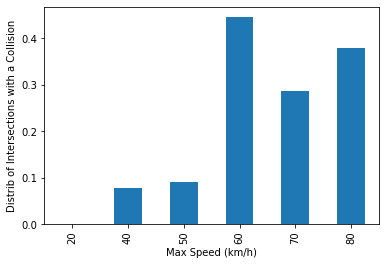

In [87]:
# Is there a collision?
(data_df[['max_speed_limit', 'geohash']].drop_duplicates()['max_speed_limit'].value_counts()/stats['max_speed_limit']).plot.bar()
plt.xlabel('Max Speed (km/h)')
plt.ylabel('Distrib of Intersections with a Collision')
plt.show()

<AxesSubplot:>

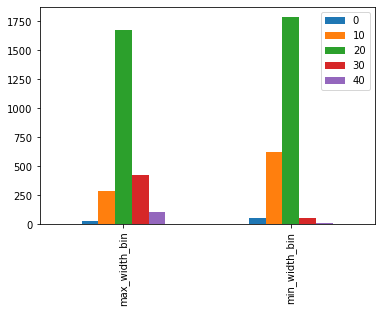

In [16]:
# Max and Min Width Distribution
pd.DataFrame([stats['max_width_bin'], stats['min_width_bin']]).sort_index().plot.bar()

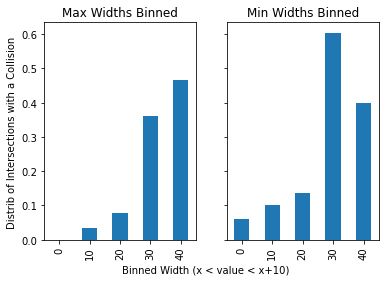

In [86]:
# Is there a collision?
max_width_binned = create_bins_10(data_df[['max_width', 'geohash']].drop_duplicates(), 'max_width')
min_width_binned = create_bins_10(data_df[['min_width', 'geohash']].drop_duplicates(), 'min_width')
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(max_width_binned['max_width_bin'].value_counts()/stats['max_width_bin']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Widths Binned")
(min_width_binned['min_width_bin'].value_counts()/stats['min_width_bin']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Widths Binned")
del max_width_binned
del min_width_binned
fig.text(0.04, 0.5, 'Distrib of Intersections with a Collision', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Binned Width (x < value < x+10)', ha='center')
plt.show()

Despite intersections with max widths between 40 and 50 metres making up a minority, there a disproportionately large number of these intersections have collisions. \
Regarding min widths, more intersections at 30 to 50 metres have collisions than expected.

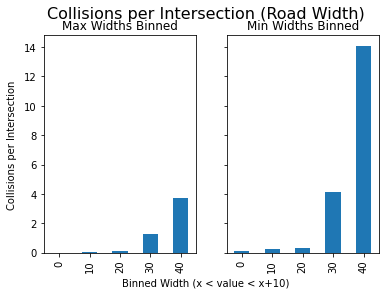

In [101]:
# Collisions per intersection
max_width_binned = create_bins_10(data_df[['max_width', 'geohash']], 'max_width')
min_width_binned = create_bins_10(data_df[['min_width', 'geohash']], 'min_width')
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(max_width_binned['max_width_bin'].value_counts()/stats['max_width_bin']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Widths Binned")
(min_width_binned['min_width_bin'].value_counts()/stats['min_width_bin']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Widths Binned")
del max_width_binned
del min_width_binned
fig.text(0.04, 0.5, 'Collisions per Intersection', va='center', rotation='vertical')
fig.suptitle("Collisions per Intersection (Road Width)", fontsize=16)
fig.text(0.5, 0.01, 'Binned Width (x < value < x+10)', ha='center')
plt.show()

As expected, there are also a higher collisions per intersection the wider the width of the intersecting roads. 

<AxesSubplot:>

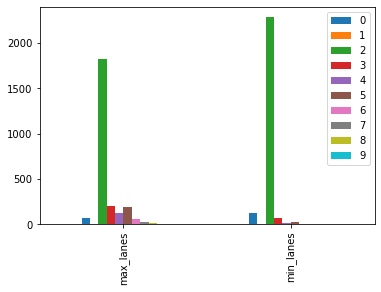

In [74]:
pd.DataFrame([stats['max_lanes'], stats['min_lanes']]).sort_index().plot.bar()

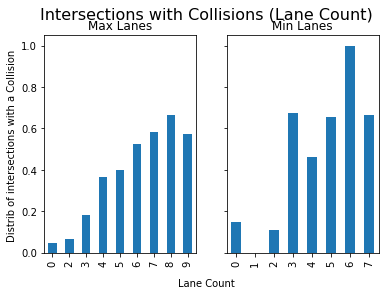

In [100]:
# Is there a collision?
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(data_df[['max_lanes', 'geohash']].drop_duplicates()['max_lanes'].value_counts()/stats['max_lanes']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Lanes")
(data_df[['min_lanes', 'geohash']].drop_duplicates()['min_lanes'].value_counts()/stats['min_lanes']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Lanes")
fig.text(0.04, 0.5, 'Distrib of intersections with a Collision', va='center', rotation='vertical')
fig.suptitle("Intersections with Collisions (Lane Count)", fontsize=16)
fig.text(0.5, 0.01, 'Lane Count', ha='center')
plt.show()

Again, despite so few intersections having a high number of max lanes, a larger proportion of them have had a motor vehicle collision. A pattern is less evident when looking at the minimum number of lanes.

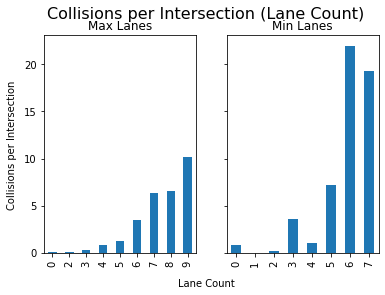

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
(data_df[['max_lanes', 'geohash']]['max_lanes'].value_counts()/stats['max_lanes']).plot.bar(ax=axes[0])
axes[0].title.set_text("Max Lanes")
(data_df[['min_lanes', 'geohash']]['min_lanes'].value_counts()/stats['min_lanes']).plot.bar(ax=axes[1])
axes[1].title.set_text("Min Lanes")
fig.text(0.04, 0.5, 'Collisions per Intersection', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Lane Count', ha='center')
fig.suptitle("Collisions per Intersection (Lane Count)", fontsize=16)
plt.show()

In [76]:
data_df[['max_lanes', 'geohash']]['max_lanes'].value_counts()

5    245
7    198
6    197
2    143
4    105
8     79
9     71
3     58
0      7
Name: max_lanes, dtype: int64